# Training Pipeline

In [201]:
%%script echo skipping
# above line causes this cell to not run

%pip install pandas numpy scikit-learn

skipping


In [202]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
import pandas as pd
import sys
from IPython.display import display
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

from config import Config

pd.options.display.max_columns = None

## Creating Datasets

It is very difficult to find authentic mixed (benign and malicious) network pcaps with a sufficient amount of DNS and TLS packets, so we will create synthetic datasets here.

https://zenodo.org/records/7958259

https://dl.acm.org/doi/pdf/10.1145/3371676.3371697

https://www.techscience.com/csse/v37n1/41440/html

https://pmc.ncbi.nlm.nih.gov/articles/PMC10857182/#B32-sensors-24-00898

https://www.sciencedirect.com/science/article/pii/S0020025522003565#s0030 --> basis for ratio of normal:malicious samples being 10:1

In [204]:
from create_datasets import DatasetCreator

path = Path(Config.MODEL_DIR) / "dns"
dns_dataset_creator = DatasetCreator(path, "dns")
path = Path(Config.MODEL_DIR) / "ssl"
tls_dataset_creator = DatasetCreator(path, "ssl")

mixed_dns = dns_dataset_creator.build_mixed_dataset(mal_min_size=1400)
mixed_tls = tls_dataset_creator.build_mixed_dataset(mal_min_size=1500)
normal_dns = dns_dataset_creator.build_normal_dataset()
normal_tls = tls_dataset_creator.build_normal_dataset()

print(f"\nFinal datasets:")
print(f"mixed DNS dataset shape: {mixed_dns.shape}")
print(f"mixed TLS dataset shape: {mixed_tls.shape}")
print(f"normal DNS dataset shape: {normal_dns.shape}")
print(f"normal TLS dataset shape: {normal_tls.shape}")

# TODO save to csv so i don't need to create over and over

mixed_dns.head()


Final datasets:
mixed DNS dataset shape: (13707, 46)
mixed TLS dataset shape: (4703, 41)
normal DNS dataset shape: (20710, 46)
normal TLS dataset shape: (3562, 41)


,uuid,uid,ts,ts_iso,duration,proto,orig_h,resp_h,orig_p,resp_p,orig_bytes,resp_bytes,orig_pkts,resp_pkts,missed_bytes,service,has_dns,has_tls,label,flow_bytes_per_sec,pkts_per_sec,pkt_ratio,approx_fwd_pkt_len_mean,approx_bwd_pkt_len_mean,query,qclass,qtype,rcode,rejected,answers,ttls,q_len,q_tld,q_max_subd_len,q_min_subd_len,q_entropy,q_num_levels,q_dig_ratio,q_consec_conso_ratio,q_alternate_ratio,q_conse_digits_ratio,num_ans,ans_len_mean,ans_entropy_mean,ttl_mean,source
0,bc3f0356-c03b-4390-964f-deea5eea6590,CYruyT2GabHIeZfRi2,127.661276,1969-12-31T21:45:53.948836,0.026339,udp,10.0.2.15,192.168.33.254,65221,53,38,82,1,1,0,dns,1,0,benign,4555.981624,75.933027,0.5,38.0,82.0,gplab1.adn.v2cdn.net,1,28,0,0,[],[],20,net,6,3,3.378783,3,0.166667,0.750000,0.307692,0.00,0,0.0,0.000000,0.0,ctu_20
1,9299f38f-9d6d-4f4d-9517-ef9a990a976c,CHOO9S3Ni6vijQBzm2,129.433831,1969-12-31T23:13:09.537675,0.028583,udp,10.0.2.15,192.168.33.254,54418,53,41,69,1,1,0,dns,1,0,benign,3848.441381,69.971661,0.5,41.0,69.0,stats.l.doubleclick.net,1,28,0,0,"[""2a00:1450:400c:c0a::9d""]",[3.0],23,net,11,1,3.454822,3,0.000000,0.705882,0.000000,0.00,1,22.0,2.954004,3.0,ctu_24
2,4a385f62-6f16-40f5-bb7e-394e1b6499ee,C15j8b2SFXeHCP5Rr4,130.991839,1969-12-31T20:20:15.901661,0.039301,udp,10.0.2.15,192.168.33.254,60199,53,32,60,1,1,0,dns,1,0,benign,2340.907356,50.889290,0.5,32.0,60.0,www.google.com,1,28,0,0,"[""2a00:1450:4016:801::2004""]",[143.0],14,com,6,3,2.197160,2,0.000000,0.666667,0.000000,0.00,1,24.0,2.802842,143.0,ctu_20
3,c765c24b-ae95-4ff9-8df5-55bc2f91a037,CvluNhaCqTvab5ya7,131.487514,1969-12-31T21:02:23.846060,0.021057,udp,10.0.2.15,192.168.33.254,53728,53,40,56,1,1,0,dns,1,0,benign,4559.053996,94.980292,0.5,40.0,56.0,e2546.d.akamaiedge.net,1,1,0,0,"[""2.19.252.132""]",[20.0],22,net,10,1,3.280639,3,0.333333,0.166667,0.133333,0.25,1,12.0,2.355389,20.0,ctu_20
4,66ac8f02-0271-4693-ac2f-526608122ce1,C9GWDJ8v0imV18r68,132.539662,1969-12-31T19:18:00.818820,0.026862,udp,10.0.2.15,192.168.33.254,64235,53,29,89,1,1,0,dns,1,0,benign,4392.822575,74.454620,0.5,29.0,89.0,twitter.com,1,28,0,0,[],[],11,com,7,7,2.128085,1,0.000000,0.571429,0.000000,0.00,0,0.0,0.000000,0.0,ctu_20


In [205]:
print(mixed_dns["source"].value_counts(), "\n")
print(mixed_tls["source"].value_counts(), "\n")
print(mixed_dns["label"].value_counts(), "\n")
print(mixed_tls["label"].value_counts(), "\n")

source
ctu_20             7000
ctu_24             5621
CTU_botnet_25_3     466
cridex_mal          466
Bladabindi_rat      154
Name: count, dtype: int64 

source
ctu_20                      2464
ctu_24                      1098
botnet                       375
CTU_SME_11_2023-02-21_AD     375
dridex_mal                   304
trickbot                      87
Name: count, dtype: int64 

label
benign        12636
malicious      1051
background       20
Name: count, dtype: int64 

label
benign       3597
malicious    1089
unknown        17
Name: count, dtype: int64 



In [206]:
mixed_tls.head()

,uuid,uid,ts,ts_iso,duration,proto,orig_h,resp_h,orig_p,resp_p,orig_bytes,resp_bytes,orig_pkts,resp_pkts,missed_bytes,service,has_dns,has_tls,label,flow_bytes_per_sec,pkts_per_sec,pkt_ratio,approx_fwd_pkt_len_mean,approx_bwd_pkt_len_mean,version,cipher,server_name,resumed,established,ssl_history,ja4,ja4s,cert_chain_fps,client_ciphers,ssl_client_exts,ssl_server_exts,num_cli_exts,num_srv_exts,num_certs,weak_cipher,source
0,2b0496a7-e89e-47ed-9b2d-63d43385d9f8,CF7p4ZxTLha65KOya,227.965664,1969-12-31T20:28:10.829596,7.843705,tcp,10.0.2.15,162.243.118.225,51176,443,925,3858,11,13,0,ssl,0,1,benign,609.788359,3.059779,0.785714,84.090909,296.769231,12,TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256,getrockerbox.com,0,1,,,,[],[],[],[],0,0,0,0,ctu_20
1,79053dce-6ae2-4d69-a40d-b2848eddb02d,C8DxQp2GNB7Z32sqz,228.711596,1969-12-31T21:35:21.247518,1.535721,tcp,10.0.2.15,174.37.183.119,65503,443,1729,1873,9,10,0,ssl,0,1,benign,2345.478117,12.372039,0.818182,192.111111,187.300000,12,TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384,www.bluehost.com,1,1,,,,[],[],[],[],0,0,0,0,ctu_20
2,59f361a1-8819-4b53-8436-3bfbff938116,CdJS1k1mYiNHHRh9Fb,236.253766,1969-12-31T20:32:55.590779,5.706668,tcp,10.0.2.15,46.255.231.54,51252,443,756,7636,13,20,0,ssl,0,1,benign,1470.560404,5.782709,0.619048,58.153846,381.800000,12,TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA,www.respekt.cz,1,1,,,,[],[],[],[],0,0,0,0,ctu_20
3,5acc23e3-d0c8-4a73-9119-84e80626db1f,C4yKKA3FPxLNGsL4N3,238.755018,1969-12-31T22:24:37.411480,47.629191,tcp,10.0.2.15,194.226.130.226,53444,443,914,3555,14,17,0,ssl,0,1,benign,93.829013,0.650861,0.777778,65.285714,209.117647,12,TLS_RSA_WITH_AES_128_CBC_SHA,www.tns-counter.ru,0,1,,,,[],[],[],[],0,0,0,0,ctu_24
4,29acba37-05b6-43da-8f5a-c940c790bdcb,Ch0u2f1UJkbOVnhjtg,238.755018,1970-01-01T01:11:57.160288,67.857331,tcp,192.168.1.113,91.82.226.222,63993,443,986,2857,8,8,0,ssl,0,1,malicious,56.633527,0.235789,0.888889,123.250000,357.125000,10,TLS_RSA_WITH_AES_128_CBC_SHA,,1,1,,,,[],[],[],[],0,0,0,0,botnet


## Data Cleaning & Analysis

In [207]:
mixed_dns.isnull().sum()

uuid                       0
uid                        0
ts                         0
ts_iso                     0
duration                   0
proto                      0
orig_h                     0
resp_h                     0
orig_p                     0
resp_p                     0
orig_bytes                 0
resp_bytes                 0
orig_pkts                  0
resp_pkts                  0
missed_bytes               0
service                    0
has_dns                    0
has_tls                    0
label                      0
flow_bytes_per_sec         0
pkts_per_sec               0
pkt_ratio                  0
approx_fwd_pkt_len_mean    0
approx_bwd_pkt_len_mean    0
query                      0
qclass                     0
qtype                      0
rcode                      0
rejected                   0
answers                    0
ttls                       0
q_len                      0
q_tld                      0
q_max_subd_len             0
q_min_subd_len

In [208]:
mixed_tls.isnull().sum()

uuid                       0
uid                        0
ts                         0
ts_iso                     0
duration                   0
proto                      0
orig_h                     0
resp_h                     0
orig_p                     0
resp_p                     0
orig_bytes                 0
resp_bytes                 0
orig_pkts                  0
resp_pkts                  0
missed_bytes               0
service                    0
has_dns                    0
has_tls                    0
label                      0
flow_bytes_per_sec         0
pkts_per_sec               0
pkt_ratio                  0
approx_fwd_pkt_len_mean    0
approx_bwd_pkt_len_mean    0
version                    0
cipher                     0
server_name                0
resumed                    0
established                0
ssl_history                0
ja4                        0
ja4s                       0
cert_chain_fps             0
client_ciphers             0
ssl_client_ext

## Feature Selection & Engineering

No feature scaling because we're using tree based models.

In [209]:
prep_dns = mixed_dns.copy()

In [210]:
prep_tls = mixed_tls.copy()

In [211]:
for df in (prep_dns, prep_tls, normal_dns, normal_tls):
    df.drop(columns=["uuid", "uid", "ts", "ts_iso", "proto"], inplace=True)
    df.drop(columns=["orig_h", "resp_h", "orig_p", "resp_p"], inplace=True)
    if df.at[0, "has_dns"] == 1:
        df.drop(columns=["query", "answers", "ttls", "q_tld"], inplace=True)
    else:
        df.drop(columns=["cipher", "server_name","ssl_history", "ja4", "ja4s", "cert_chain_fps", "client_ciphers", "ssl_client_exts", "ssl_server_exts"], inplace=True)
    df.drop(columns=["service", "has_dns", "has_tls", "source"], inplace=True)
    
    df = pd.get_dummies(df, dtype=int)

In [212]:
# Convert to lowercase first, then map to 0/1
prep_dns["label_enc"] = (
    prep_dns["label"]
    .astype(str)
    .str.lower()
    .map({"malicious": 1, "benign": 0, "background": 0, "unknown": 0})
)

prep_tls["label_enc"] = (
    prep_tls["label"]
    .astype(str)
    .str.lower()
    .map({"malicious": 1, "benign": 0, "background": 0, "unknown": 0})
)

prep_dns.drop(columns=["label"], inplace=True)
prep_tls.drop(columns=["label"], inplace=True)
normal_dns.drop(columns=["label"], inplace=True)
normal_tls.drop(columns=["label"], inplace=True)

In [213]:
prep_dns.info()

<class 'pandas.DataFrame'>
RangeIndex: 13707 entries, 0 to 13706
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   duration                 13707 non-null  float64
 1   orig_bytes               13707 non-null  int64  
 2   resp_bytes               13707 non-null  int64  
 3   orig_pkts                13707 non-null  int64  
 4   resp_pkts                13707 non-null  int64  
 5   missed_bytes             13707 non-null  int64  
 6   flow_bytes_per_sec       13707 non-null  float64
 7   pkts_per_sec             13707 non-null  float64
 8   pkt_ratio                13707 non-null  float64
 9   approx_fwd_pkt_len_mean  13707 non-null  float64
 10  approx_bwd_pkt_len_mean  13707 non-null  float64
 11  qclass                   13707 non-null  int64  
 12  qtype                    13707 non-null  int64  
 13  rcode                    13707 non-null  int64  
 14  rejected                 13707 no

In [214]:
prep_tls.info()

<class 'pandas.DataFrame'>
RangeIndex: 4703 entries, 0 to 4702
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   duration                 4703 non-null   float64
 1   orig_bytes               4703 non-null   int64  
 2   resp_bytes               4703 non-null   int64  
 3   orig_pkts                4703 non-null   int64  
 4   resp_pkts                4703 non-null   int64  
 5   missed_bytes             4703 non-null   int64  
 6   flow_bytes_per_sec       4703 non-null   float64
 7   pkts_per_sec             4703 non-null   float64
 8   pkt_ratio                4703 non-null   float64
 9   approx_fwd_pkt_len_mean  4703 non-null   float64
 10  approx_bwd_pkt_len_mean  4703 non-null   float64
 11  version                  4703 non-null   int64  
 12  resumed                  4703 non-null   int64  
 13  established              4703 non-null   int64  
 14  num_cli_exts             4703 non-n

## Training Models

Most papers use Random Forest but XGBoost outperforms with smaller, tabular data. It would be worthwhile to train randomforest models (range library) and compare results.

Goal is to minimize false negatives, thus we aim to maximize recall.

https://papers.nips.cc/paper_files/paper/2007/hash/be83ab3ecd0db773eb2dc1b0a17836a1-Abstract.html

Note that all datasets are unbalanced. While it is not uncommon for researches to use different methods to balance datasets (ex. SMOTE, under/over-sampling), based on my own research I decided against it. XGBoost has parameters to help account for unbalanced classes and it seems like many of the formerly mentioned methods are "hacks" of implementing importance estimation/weighing (see above) and I need to do more research on it.

In [215]:
train_dns = prep_dns.copy()
train_tls = prep_tls.copy()

### Training DNS Model

In [ ]:
from sklearn.model_selection import train_test_split

dns_label = train_dns["label_enc"]
train_dns.drop(columns="label_enc", inplace=True)

# creating the training/validation/test datasets
# this is ~70/15/15 split
dx_train, dx_test, dy_train, dy_test = train_test_split(train_dns, dns_label, test_size=0.3, random_state=42)

# stratify preserves the ratio btwn classes in the OG dataset
dx_temp, dx_test, dy_temp, dy_test = train_test_split(
    dx_train, dy_train, test_size=0.15, random_state=42, stratify=dy_train
)
dx_train_final, dx_val, dy_train_final, dy_val = train_test_split(
    dx_temp, dy_temp, test_size=0.176, random_state=42, stratify=dy_temp
)

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# calculating the ratio of positive and negative samples
normal_count = np.sum(dy_train_final == 0)
malicious_count = np.sum(dy_train_final == 1)
scale_pos_weight = normal_count / malicious_count if malicious_count > 0 else 1

dns_params = {
    "max_depth": [3, 5, 6, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

dns_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "aucpr"],
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=4,
    n_estimators=1000
)

random_search = RandomizedSearchCV(
    dns_model, dns_params, n_iter=5, scoring="recall", cv=3, verbose=1, n_jobs=2
)
random_search.fit(dx_train_final, dy_train_final)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best recall: {random_search.best_score_:.4f}")

dns_model = random_search.best_estimator_

Running quick parameter search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best recall: 0.9420


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# get probabilities
test_probas = dns_model.predict_proba(dx_test)[:, 1]

# checking different thresholds to see which maximizes results
low_thresholds = [0.01, 0.02, 0.03]
best_recall = 0
dns_best_threshold = 0

for threshold in low_thresholds:
    preds = (test_probas > threshold).astype(int)
    recall = recall_score(dy_test, preds)
    precision = precision_score(dy_test, preds)
    f1 = f1_score(dy_test, preds)
    
    print(f"Threshold {threshold:.3f}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")
    
    if recall > best_recall:
        best_recall = recall
        dns_best_threshold = threshold
    elif recall == best_recall:
        dns_best_threshold = max(dns_best_threshold, threshold)

print(f"\nBest threshold for recall: {dns_best_threshold} (Recall: {best_recall:.4f})")


FINDING BEST THRESHOLD FOR HIGH RECALL
Threshold 0.010: Recall=0.9820, Precision=0.5117, F1=0.6728
Threshold 0.020: Recall=0.9820, Precision=0.6566, F1=0.7870
Threshold 0.030: Recall=0.9730, Precision=0.7248, F1=0.8308

✓ Best threshold for recall: 0.02 (Recall: 0.9820)



CONFUSION MATRIX

Performance:
Recall: 0.9820
Precision: 0.6566
F1-Score: 0.7870
Accuracy: 0.9590


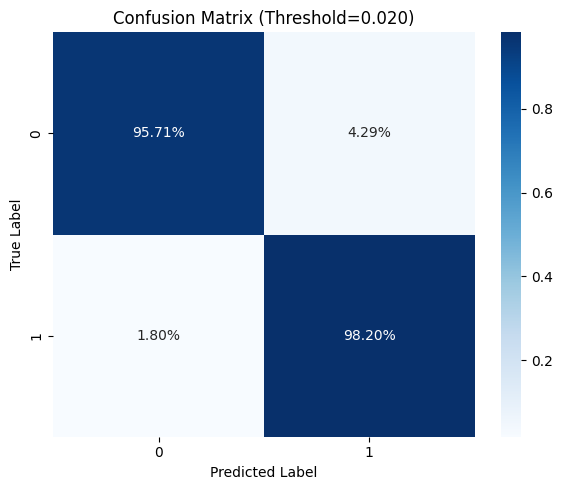

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

final_preds = (test_probas > dns_best_threshold).astype(int)
cm = confusion_matrix(dy_test, final_preds)
# display as percentages
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm,
            annot=True,
            fmt='.2%',
            cmap='Blues')

print(f"\nPerformance:")
print(f"Recall: {recall_score(dy_test, final_preds):.4f}")
print(f"Precision: {precision_score(dy_test, final_preds):.4f}")
print(f"F1-Score: {f1_score(dy_test, final_preds):.4f}")
print(f"Accuracy: {accuracy_score(dy_test, final_preds):.4f}")

plt.title(f"Confusion Matrix (Threshold={dns_best_threshold:.3f})")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Training TLS Model

Very similar to the above.

In [ ]:
from sklearn.model_selection import train_test_split

tls_label = train_tls["label_enc"]
train_tls.drop(columns="label_enc", inplace=True)

sx_train, sx_test, sy_train, sy_test = train_test_split(train_tls, tls_label, test_size=0.3, random_state=42)

sx_temp, sx_test, sy_temp, sy_test = train_test_split(
    sx_train, sy_train, test_size=0.15, random_state=42, stratify=sy_train
)
sx_train_final, sx_val, sy_train_final, sy_val = train_test_split(
    sx_temp, sy_temp, test_size=0.176, random_state=42, stratify=sy_temp
)

normal_count = np.sum(sy_train_final == 0)
malicious_count = np.sum(sy_train_final == 1)
scale_pos_weight_tls = normal_count / malicious_count

print(f"TLS Dataset Info:")
print(f"Normal (benign): {normal_count}")
print(f"Malicious: {malicious_count}")
print(f"Imbalance ratio: {scale_pos_weight_tls:.2f}:1")
print(f"Scale pos weight: {scale_pos_weight_tls:.2f}")
print("-" * 50)

param_dist = {
    "max_depth": [3, 5, 6, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "min_child_weight": [1, 3, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
}

tls_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "aucpr"],
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=4,
    n_estimators=1000
)

random_search = RandomizedSearchCV(
    tls_model, param_dist, n_iter=5, scoring="recall", cv=3, verbose=1, n_jobs=2
)
random_search.fit(sx_train_final, sy_train_final)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best recall: {random_search.best_score_:.4f}")

tls_model = random_search.best_estimator_

TLS Dataset Info:
Normal (benign): 1780
Malicious: 525
Imbalance ratio: 3.39:1
Scale pos weight: 3.39
--------------------------------------------------
Running TLS parameter search...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best parameters: {'subsample': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best recall: 0.9981


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# FIXME type error but code still works
test_probas = tls_model.predict_proba(sx_test)[:, 1]

low_thresholds = [0.03, 0.04, 0.05]
best_recall = 0
tls_best_threshold = 0.3

for threshold in low_thresholds:
    preds = (test_probas > threshold).astype(int)
    recall = recall_score(sy_test, preds)
    precision = precision_score(sy_test, preds)
    f1 = f1_score(sy_test, preds)
    
    print(f"Threshold {threshold:.3f}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")
    
    if recall > best_recall:
        best_recall = recall
        tls_best_threshold = threshold
    elif recall == best_recall:
        tls_best_threshold = max(tls_best_threshold, threshold)

print(f"\n✓ Best threshold for recall: {tls_best_threshold} (Recall: {best_recall:.4f})")


FINDING BEST THRESHOLD FOR HIGH RECALL
Threshold 0.020: Recall=1.0000, Precision=0.9032, F1=0.9492
Threshold 0.030: Recall=1.0000, Precision=0.9412, F1=0.9697
Threshold 0.040: Recall=1.0000, Precision=0.9412, F1=0.9697
Threshold 0.050: Recall=1.0000, Precision=0.9412, F1=0.9697

✓ Best threshold for recall: 0.05 (Recall: 1.0000)



CONFUSION MATRIX

Performance:
Recall: 1.0000
Precision:0.9412
F1-Score: 0.9697
Accuracy: 0.9858


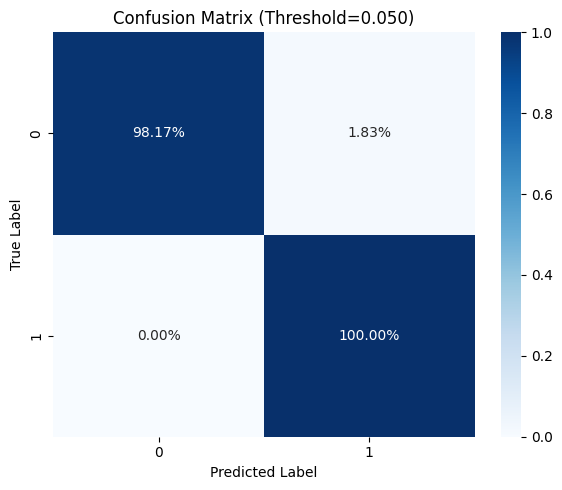

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


final_preds = (test_probas > tls_best_threshold).astype(int)
cm = confusion_matrix(sy_test, final_preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, 
            annot=True, 
            fmt='.2%', 
            cmap='Blues')

print(f"\nPerformance:")
print(f"Recall: {recall_score(sy_test, final_preds):.4f}")
print(f"Precision:{precision_score(sy_test, final_preds):.4f}")
print(f"F1-Score: {f1_score(sy_test, final_preds):.4f}")
print(f"Accuracy: {accuracy_score(sy_test, final_preds):.4f}")

plt.title(f"Confusion Matrix (Threshold={tls_best_threshold:.3f})")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

## Save Models

In [ ]:
from joblib import dump
import json

# Create a dictionary with everything
dns_package = {
    "model": dns_model,
    "features": dx_train.columns.tolist(),
    "threshold": dns_best_threshold,
    "metadata": {
        "model_type": "XGBoost",
        "dataset": "Malicious DNS Traffic",
    }
}

tls_package = {
    "model": tls_model,
    "features": sx_train.columns.tolist(),
    "threshold": tls_best_threshold,
    "metadata": {
        "model_type": "XGBoost",
        "dataset": "Malicious TLS Traffic",
    }
}

# Save everything at once
dump(dns_package, "models/dns_model_package.pkl")
dump(tls_package, "models/tls_model_package.pkl")


skipping
